For this notebook to work do:

* Install Mantid version 3.12 (or higher) 

* On **Windows**, from a command prompt <br>
  `type c:/MantidInstall/bin/mantidpython.bat notebook`

* on **MacOS**, from a terminal type <br>
  `Applications/MantidPlot.app/Contents/MacOS/mantidpython notebook`
  
* on **Linux**, **TO BE COMPLETED** <br>

For more info on working with IPython/Jupyter and Mantid see also: http://www.mantidproject.org/Using_IPython_Notebook <br>

For example to run the notebook on Mac, in a terminal move to the 'examples' folder of the QENS library and type <br>
`/Applications/MantidPlot.app/Contents/MacOS/mantidpython notebook`

**Setup Mantid**

In [47]:
import sys
import os

#Tell Python where Mantid is installed.
#The official packages put this information in an environment variable called "MANTIDPATH"
sys.path.append(os.environ['MANTIDPATH'])
# for example, on Mac, it is '/Applications/MantidPlot.app/Contents/MacOS'

#We can now import Mantid's Python API
from mantid.simpleapi import *

** Setup QENS models library**

In [40]:
import QENSmodels

**Setup matplotlib, numpy etc**

In [41]:
import numpy as np
from scipy.constants import pi

#Some magic to tell matplotlib how to behave in IPython Notebook
%matplotlib inline

import matplotlib.pyplot as plt

### Load data

In [42]:
# Path to where the data for the examples are (/QENSmodels/examples/data)
path_to_data = os.path.join(os.getcwd(), 'data/')

# experimental data
ws_5Aini = LoadLamp(path_to_data+'H2O_293K_5A.hdf')

# vanadium
res_5Aini = LoadLamp(path_to_data+'V_273K_5A.hdf')

hw_5A = ws_5Aini.readX(0)

idx_5A = np.where(np.logical_and(hw_5A > -1.0, hw_5A < 1.0))
index_4_trunc_5A = idx_5A[0].tolist()

print('Number of histograms and blocksize for data workspace', ws_5Aini.getNumberHistograms(), ws_5Aini.blocksize())
print('Number of histograms and blocksize for resolution workspace', res_5Aini.getNumberHistograms(), res_5Aini.blocksize())

('Number of histograms and blocksize for data workspace', 17, 160)
('Number of histograms and blocksize for resolution workspace', 17, 160)


In [43]:
# Force resolution function to have unit area
norm_res_5A = CloneWorkspace(res_5Aini)

for i in range(res_5Aini.getNumberHistograms()):
    area = Integration(res_5Aini, StartWorkspaceIndex=i, EndWorkspaceIndex=i)
    y_norm = norm_res_5A.dataY(i)
    y_norm /= area.readY(0)[0]

# Fit range -1meV < energy < 1 meV
x = hw_5A[index_4_trunc_5A]

# Apply truncation to data
ws_5A = CropWorkspace(ws_5Aini, XMin=-1, Xmax=1)

# Same procedure for normalised resolution
res_5A = CropWorkspace(norm_res_5A,  XMin=-1, XMax=1)

# Extract values of q to be used in parameters of fitting models
q_5A = ws_5A.getAxis(1).extractValues()

# Remove invalid data (negative errors)
for ii in range(len(q_5A)):
    yy = ws_5A.dataY(ii)
    err = ws_5A.dataE(ii)
    for jj in range(ws_5A.blocksize()):
        if err[jj] <= 0:
            yy[jj] = 0
            err[jj] = 0

### Definition of fitting model
References in Mantid:
- https://www.mantidproject.org/Python_Function_Attributes

- http://docs.mantidproject.org/nightly/api/python/mantid/api/IFunction1D.html?highlight=ifunction1d#mantid.api.IFunction1D.fixParameter

- http://docs.mantidproject.org/nightly/concepts/FitFunctionsInPython.html?highlight=multidomainfunction

In [15]:
class MyModel(IFunction1D):
    """  Definition of model = sum of lorentzian and sqwIsotropicRotationalDiffusion from QENS library
    To be used as a fitting model in Mantid """
    def init(self):
        self.declareAttribute("Q", 1.)
        self.declareParameter("scale_factor", 20.)
        self.declareParameter("centre", 0.) 
        self.declareParameter("hwhm", 1.)
        self.declareParameter("radius", 0.98) 
        self.declareParameter("DR", 2.)
        
    def setAttributeValue(self, name, value):
        if name == "Q":
            self._Q = value
            
    def function1D(self, w):
        # Access current values during the fit
        Q = self.getAttributeValue("Q")
        scale_factor = self.getParameterValue("scale_factor")
        centre = self.getParameterValue("centre")
        hwhm = self.getParameterValue("hwhm")
        radius = self.getParameterValue("radius")
        DR = self.getParameterValue("DR")
        
        my_model = QENSmodels.lorentzian(w, scale_factor, centre, hwhm) 
        + QENSmodels.sqwIsotropicRotationalDiffusion(w, Q, scale_factor, centre, radius, DR)

        return my_model

FunctionFactory.subscribe(MyModel)

# user defined model of lorentzian + IsotropicRotationalDiffusion
sum_lorentz_isorot = MyModel()

# Resolution
res_func = Resolution(Workspace='res_5A', WorkspaceIndex=0)

In [16]:
# Attribute and parameters of my_model
print('Attributes of user model (lorentzian+ iso rot diff):')
print('Name of attribute: {}'.format(sum_lorentz_isorot.attributeNames()))
for i in range(sum_lorentz_isorot.nParams()):
    print('Name of {}th parameter'.format(i), sum_lorentz_isorot.parameterName(i))

Attributes of user model (lorentzian+ iso rot diff):
Name of attribute: ['Q']
('Name of 0th parameter', 'scale_factor')
('Name of 1th parameter', 'centre')
('Name of 2th parameter', 'hwhm')
('Name of 3th parameter', 'radius')
('Name of 4th parameter', 'DR')


In [17]:
# Attribute and parameters of res_func
print('Number of attributes of resolution function', res_func.nAttributes())
print('Number of parameters of resolution function', res_func.nParams())
print('Attributes of resolution function:')
print(res_func.attributeNames())

('Number of attributes of resolution function', 5)
('Number of parameters of resolution function', 0)
Attributes of resolution function:
['FileName','Workspace','WorkspaceIndex','X','Y']


In [18]:
# Check if user defined model is equal to the sum of related QENS models
# Test values
w0 = 2.
Q0 = 0.833
scale_factor0 = 20.
centre0 = 0.0
hwhm0 = 0.01
radius0 = 0.98
DR0 = 2.

print('Number of attributes in model:', sum_lorentz_isorot.nAttributes())
print('Number of parameters in model:', sum_lorentz_isorot.nParams())

sum_lorentz_isorot.setAttributeValue('Q', Q0)

for i in range(sum_lorentz_isorot.nParams()):
        print('Name of {0}th parameter: {1}'.format(i, sum_lorentz_isorot.parameterName(i)))

print("Evaluation of my_model with test values:", 
      sum_lorentz_isorot(w0, scale_factor0, centre0, hwhm0, radius0, DR0))

print("Evaluation of explicit sum of QENSmodels functions with test values:", 
      QENSmodels.lorentzian(w0, scale_factor0, centre0, hwhm0) 
      + QENSmodels.sqwIsotropicRotationalDiffusion(w0, Q0, scale_factor0, centre0, radius0, DR0))

('Number of attributes in model:', 1)
('Number of parameters in model:', 5)
Name of 0th parameter: scale_factor
Name of 1th parameter: centre
Name of 2th parameter: hwhm
Name of 3th parameter: radius
Name of 4th parameter: DR
('Evaluation of my_model with test values:', 0.26781138277169858)
('Evaluation of explicit sum of QENSmodels functions with test values:', array([ 0.26781138]))


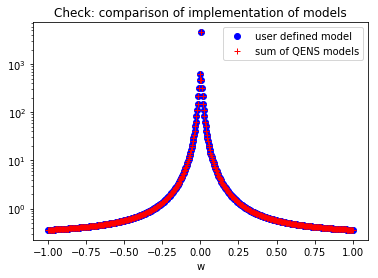

In [20]:
# Check: plot of user defined model and of the sum of related QENS models
w = np.linspace(-1,1,500)

plt.plot(w, sum_lorentz_isorot(w, scale_factor0, centre0, hwhm0, radius0, DR0), 
         'bo', 
         label='user defined model')

plt.plot(w, QENSmodels.lorentzian(w, scale_factor0, centre0, hwhm0) 
         + QENSmodels.sqwIsotropicRotationalDiffusion(w, Q0, scale_factor0, centre0, radius0, DR0), 
         'r+',
        label='sum of QENS models')

plt.yscale('log')
plt.xlabel('w')
plt.title('Check: comparison of implementation of models')
plt.legend()
plt.show()

In [27]:
def single_model(workspace_index):
    """ Define convolution function of resolution and user defined model
    with initial values of parameters
    To be used to create global model of all Q-values"""
    return Convolution(Resolution(Workspace='res_5A', WorkspaceIndex=workspace_index),
                       MyModel(Q=q_5A[workspace_index],
                               scale_factor=20,
                               centre=0,
                               hwhm=0.1,
                               radius=0.98,
                               DR=2.),                  
                       FixResolution=True, 
                       NumDeriv=True)

Q = 0.5, Number of parameters: 5, Number of attributes: 2
Name of 0th parameter: f1.scale_factor
Name of 1th parameter: f1.centre
Name of 2th parameter: f1.hwhm
Name of 3th parameter: f1.radius
Name of 4th parameter: f1.DR
Q = 0.6, Number of parameters: 5, Number of attributes: 2
Name of 0th parameter: f1.scale_factor
Name of 1th parameter: f1.centre
Name of 2th parameter: f1.hwhm
Name of 3th parameter: f1.radius
Name of 4th parameter: f1.DR
Q = 0.7, Number of parameters: 5, Number of attributes: 2
Name of 0th parameter: f1.scale_factor
Name of 1th parameter: f1.centre
Name of 2th parameter: f1.hwhm
Name of 3th parameter: f1.radius
Name of 4th parameter: f1.DR
Q = 0.8, Number of parameters: 5, Number of attributes: 2
Name of 0th parameter: f1.scale_factor
Name of 1th parameter: f1.centre
Name of 2th parameter: f1.hwhm
Name of 3th parameter: f1.radius
Name of 4th parameter: f1.DR
Q = 0.9, Number of parameters: 5, Number of attributes: 2
Name of 0th parameter: f1.scale_factor
Name of 1th

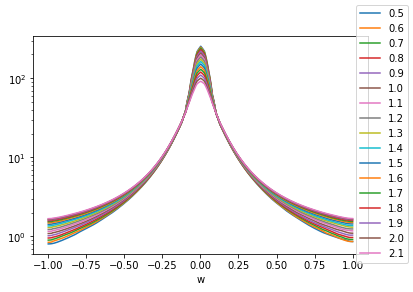

In [28]:
# Check profile, names of attributes and parameters of convolution function for all Q-values
w = np.linspace(-1, 1, 500)
for indx, Q in enumerate(q_5A):
    single_model_Q = single_model(indx)    
    plt.plot(w, single_model_Q(w), label='%.1f'%Q)
    print('Q = {0:.1f}, Number of parameters: {1}, Number of attributes: {2}'.format(Q, 
                                                                                     single_model_Q.nParams(), 
                                                                                     single_model_Q.nAttributes()))
    
    for i in range(single_model_Q.nParams()): 
        print('Name of {0}th parameter: {1}'.format(i, single_model_Q.parameterName(i)))
        
plt.yscale('log')
plt.figlegend()
plt.xlabel('w')
plt.show()

In [34]:
# Create global model
global_model = MultiDomainFunction(single_model(0), 
                                   single_model(1), 
                                   single_model(2),
                                   single_model(3), 
                                   single_model(4), 
                                   single_model(5), 
                                   single_model(6),
                                   single_model(7), 
                                   single_model(8),
                                   single_model(9), 
                                   single_model(10), 
                                   single_model(11), 
                                   single_model(12), 
                                   single_model(13), 
                                   single_model(14), 
                                   single_model(15),
                                   single_model(16), Global=['f1.DR', 'f1.radius'])

# Print parameters of global model
for i in range(global_model.nParams()):
        print('Name of {0}th parameter: {1}'.format(i, global_model.parameterName(i)))

global_model.constrain("f0.f1.scale_factor > 0.")
global_model.constrain("f1.f1.scale_factor > 0.")
global_model.constrain("f2.f1.scale_factor > 0.")
global_model.constrain("f3.f1.scale_factor > 0.")
global_model.constrain("f4.f1.scale_factor > 0.")
global_model.constrain("f5.f1.scale_factor > 0.")
global_model.constrain("f6.f1.scale_factor > 0.")
global_model.constrain("f7.f1.scale_factor > 0.")
global_model.constrain("f8.f1.scale_factor > 0.")
global_model.constrain("f9.f1.scale_factor > 0.")
global_model.constrain("f10.f1.scale_factor > 0.")
global_model.constrain("f11.f1.scale_factor > 0.")
global_model.constrain("f12.f1.scale_factor > 0.")
global_model.constrain("f13.f1.scale_factor > 0.")
global_model.constrain("f14.f1.scale_factor > 0.")
global_model.constrain("f15.f1.scale_factor > 0.")
global_model.constrain("f16.f1.scale_factor > 0.")

global_model.constrain("f0.f1.hwhm > 0.")
global_model.constrain("f1.f1.hwhm > 0.")
global_model.constrain("f2.f1.hwhm > 0.")
global_model.constrain("f3.f1.hwhm > 0.")
global_model.constrain("f4.f1.hwhm > 0.")
global_model.constrain("f5.f1.hwhm > 0.")
global_model.constrain("f6.f1.hwhm > 0.")
global_model.constrain("f7.f1.hwhm > 0.")
global_model.constrain("f8.f1.hwhm > 0.")
global_model.constrain("f9.f1.hwhm > 0.")
global_model.constrain("f10.f1.hwhm > 0.")
global_model.constrain("f11.f1.hwhm > 0.")
global_model.constrain("f12.f1.hwhm > 0.")
global_model.constrain("f13.f1.hwhm > 0.")
global_model.constrain("f14.f1.hwhm > 0.")
global_model.constrain("f15.f1.hwhm > 0.")
global_model.constrain("f16.f1.hwhm > 0.")

global_model.constrain("f0.f1.DR > 0.")

Name of 0th parameter: f0.f1.scale_factor
Name of 1th parameter: f0.f1.centre
Name of 2th parameter: f0.f1.hwhm
Name of 3th parameter: f0.f1.radius
Name of 4th parameter: f0.f1.DR
Name of 5th parameter: f1.f1.scale_factor
Name of 6th parameter: f1.f1.centre
Name of 7th parameter: f1.f1.hwhm
Name of 8th parameter: f1.f1.radius
Name of 9th parameter: f1.f1.DR
Name of 10th parameter: f2.f1.scale_factor
Name of 11th parameter: f2.f1.centre
Name of 12th parameter: f2.f1.hwhm
Name of 13th parameter: f2.f1.radius
Name of 14th parameter: f2.f1.DR
Name of 15th parameter: f3.f1.scale_factor
Name of 16th parameter: f3.f1.centre
Name of 17th parameter: f3.f1.hwhm
Name of 18th parameter: f3.f1.radius
Name of 19th parameter: f3.f1.DR
Name of 20th parameter: f4.f1.scale_factor
Name of 21th parameter: f4.f1.centre
Name of 22th parameter: f4.f1.hwhm
Name of 23th parameter: f4.f1.radius
Name of 24th parameter: f4.f1.DR
Name of 25th parameter: f5.f1.scale_factor
Name of 26th parameter: f5.f1.centre
Name 

In [35]:
# Now relate each domain(i.e. spectrum) to each single model
domain_model = dict()
for wi in range(len(q_5A)):
    if wi == 0:
        domain_model.update({"InputWorkspace": ws_5A.name(), "WorkspaceIndex": str(wi),
            "StartX": "-1", "EndX": "1"})
    else:
        domain_model.update({"InputWorkspace_"+str(wi): ws_5A.name(), "WorkspaceIndex_"+str(wi): str(wi),
            "StartX_"+str(wi): "-1", "EndX_"+str(wi): "1"})

In [44]:
# Invoke the Fit algorithm using global_model and domain_model:
output_workspace = "glofit_"+ws_5A.name()
fit_output = Fit(Function=global_model, Output=output_workspace, CreateOutput=True, **domain_model)

In [45]:
# Print some results
fitWorkspace = fit_output.OutputWorkspace
paramTable = fit_output.OutputParameters

# print results for refined parameters
print('Table of refined parameters: Name Value Error')

for i in range(paramTable.rowCount()):
    print(paramTable.column(0)[i],
          paramTable.column(1)[i],
          paramTable.column(2)[i])

Table of refined parameters: Name Value Error
('f0.f1.scale_factor', 10.180877595249145, 0.006825148536121698)
('f0.f1.centre', 0.0008770448864115229, 6.66097051366152e-05)
('f0.f1.hwhm', 0.03663178399692257, 0.00012729649971706473)
('f0.f1.radius', 3.5441244565796546, 0.007382537413958937)
('f0.f1.DR', 0.030591197125929927, 0.00012526447110897172)
('f1.f1.scale_factor', 10.20487407423023, 0.006671783395546391)
('f1.f1.centre', 0.0016699744534443696, 7.176637705904375e-05)
('f1.f1.hwhm', 0.04905488943794849, 0.00015845219362222744)
('f1.f1.radius', 3.5441244565796546, 0.0)
('f1.f1.DR', 0.030591197125929927, 0.0)
('f2.f1.scale_factor', 10.233712766865306, 0.006666976367493061)
('f2.f1.centre', 0.0025711572477001756, 7.955967139323636e-05)
('f2.f1.hwhm', 0.06282721154153255, 0.0001886286991912525)
('f2.f1.radius', 3.5441244565796546, 0.0)
('f2.f1.DR', 0.030591197125929927, 0.0)
('f3.f1.scale_factor', 10.348201564813605, 0.006659728654478555)
('f3.f1.centre', 0.0038193816350550864, 8.9920

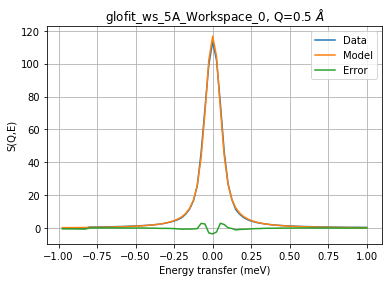

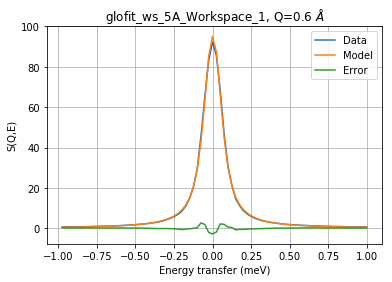

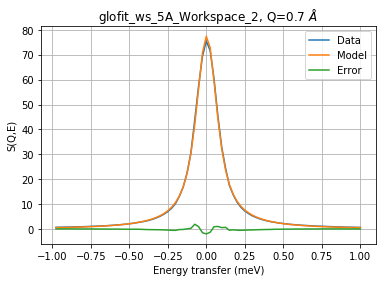

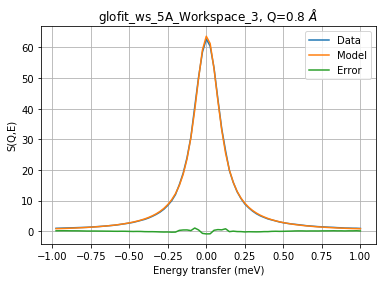

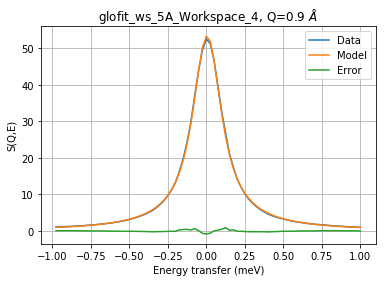

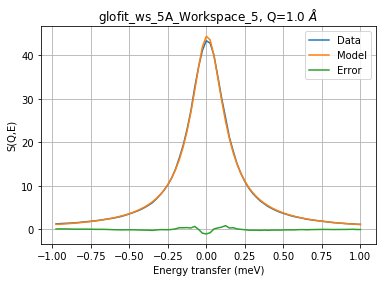

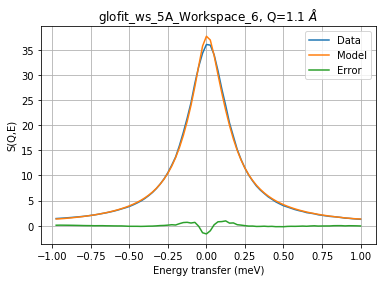

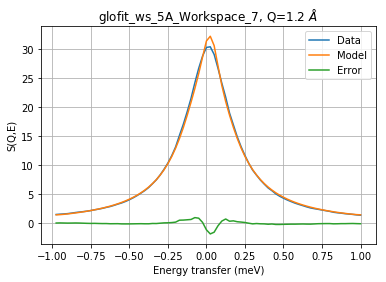

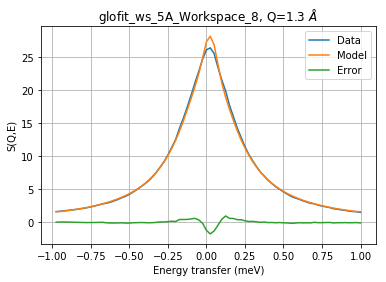

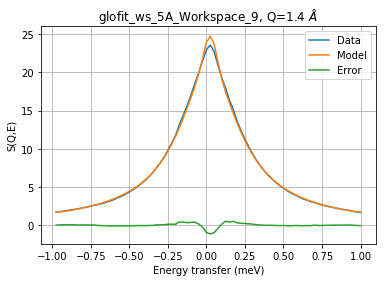

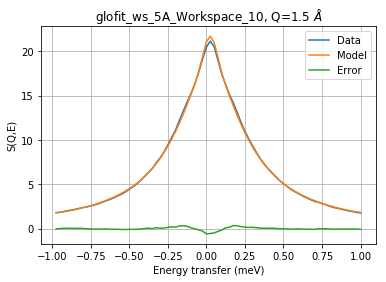

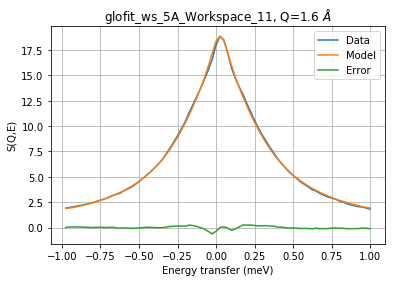

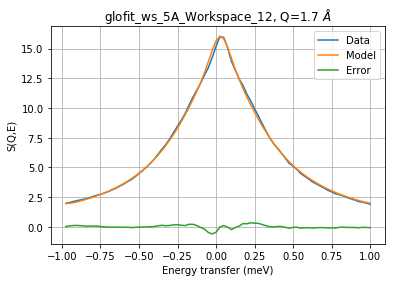

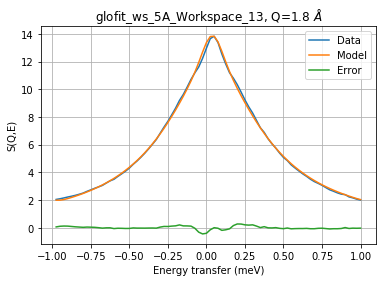

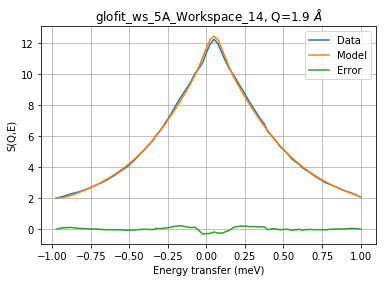

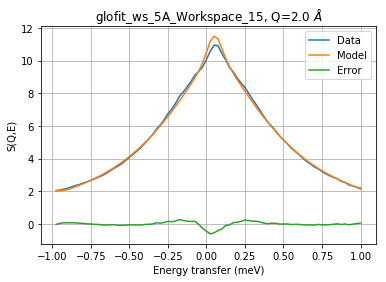

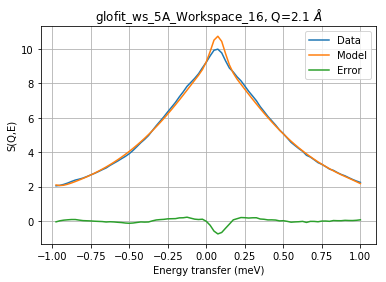

In [46]:
# Plot results: one plot / spectrum showing experimental, fitted data
# and difference

for indx, item in enumerate(fitWorkspace.getNames()):
    x = mtd[item].readX(0)
    plt.plot(x, mtd[item].readY(0), label="Data")
    plt.plot(x, mtd[item].readY(1), label="Model")
    plt.plot(x, mtd[item].readY(2), label="Error")
    plt.xlabel('Energy transfer (meV)')
    plt.ylabel('S(Q,E)')
    plt.legend()
    plt.grid()
    plt.title(item + r", Q={:.1f} $\AA$".format(q_5A[indx]))
    plt.show()